# Assignment #8

I have posted the pdf of the book "Geostatistics for Environmental Scientists" on Sakai. It provides a nice comprehensive introduction to the material.

# 1. Probabilistic basis of Geostatistics (25 pts)

Each observation of an environmental variable in space $z(\mathbf{x})$ can be interpreted as a single realization of a random variable $Z(\mathbf{x})$. Where $\mathbf{x}$ denotes the position in space of the observation. In a given finite region there can be an infinite number of locations $\mathbf{x}$ and thus an infinite number of random variables $Z(\mathbf{x})$. The set of all these random variables $Z(\mathbf{x})$ constitutes a random process. For the remainder of this problem assume $Z_i = Z(\mathbf{x})$ and $z_i = z(\mathbf{x})$.

A. Explain the difference between $z_i$ and $Z_i$.

B. Based on the lectures, define $Z^*$ and $Z_0$. Explain the difference between the two. 

C. Describe the meaning of $\text{Cov}(Z_i,Z_j)$, $\text{Cov}(Z_i,Z_0)$, $\text{Var}(Z_0)$.

D. The Simple Kriging system is given by $\Sigma \mathbf{w} = \mathbf{c}$. Explain each term in that equation.

E. Once $\mathbf{w}$ is computed, how can it be used to estimate $z^*$? 

F. What is second-order stationarity?

F. Assuming second-order stationarity, if we are interested in the covariance between $Z_i$ and $Z_j$, why do we concern ourselves with the semivariogram?


## Answer:
A.
zi is the cloest observation to z0 (the true unknown value of the evaluated point), and Zi is a random variable consisted of zi which denotes a vector including several zi (the cloest n observations to z0).

B.
Z* is the estimate of the true unknow value of Z0, which can be represented by the following expression: 𝑍* = sum(wi*zi) with i from i=0 to i=N. There is a weighting vector used to equalize the two.

C.
Cov(Zi, Zj) is a covariance matrix including the covariances of all observation data points with respect to each other. Cov(Zi, Z0) is a covariacne matrix including the covariances of all observation data points with Z0, the true unknow value of the evaluated points vector.
Var(Z0) is the variance of the true values of the missing points.

D.
Σ is the Cov(Zi, Zj), which is the covariance matrix of the observation data. w is the weighting vector of the observation data. c is the vector consisted of all true values of the missing points.

E.
It can be calculated using the following equation: 𝑍* = sum(wi*zi) with i from i=0 to i=N

F.
Second-order stationarity is an attribution of a time series that has a constant mean, variance and an autocovariance with time.

G.
Because we need to have semivariogram first in order to calculate the covariance between Zi and Zj. As the relationship between the covariacne and the semivariogram is defined as follow: 𝛾(ℎ)=𝐶(0)−𝐶(ℎ)

# 2. Computing the semivariogram (25 pts)

Using data from the samples group in `/data/HW/HW8.nc`:

A. Assemble the isotropic cloud semivariogram. Plot the results. Only consider distances up to 25000 m. 

B. Having computed the cloud semivariogram, assemble the sample semivariogram using a bin size of 500 m. Plot the results. Only consider distances up to 25000 m.

C. Fit an exponential, spherical, and bounded linear semivariogram to the sample semivariogram. Compute the $R^2$ of each fit then plot the results. Remember to set bounds for the curve fitting, if not, it won't converge. Based on your results, which model semivariogram would you use for the region?

In [1]:
file = '/data/HW/HW8.nc'

import netCDF4 as nc
fp = nc.Dataset(file)

In [2]:
import sklearn.model_selection
import numpy as np

data = fp['samples']['sand'][:]
x = fp['samples']['x'][:]
y = fp['samples']['y'][:]

In [3]:
# Compute euclidean distances between the points
h = (((x[:,np.newaxis].T - x[:,np.newaxis])**2)+((y[:,np.newaxis].T - y[:,np.newaxis])**2))**0.5

# Compute variogram cloud by comparing all points
gamma_c = (data[:,np.newaxis].T - data[:,np.newaxis])**2/2

#Reshape to 1d arrays
h = h.reshape(h.size)
gamma_c = gamma_c.reshape(gamma_c.size)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

#Make the scatter plot
plt.scatter(h,gamma_c)

#Let's only consider points that are up to 25000 meters away from each other
plt.xlim([0,25000])

#Pretty up the plot
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h_{i,j} (m)$',fontsize=40)
plt.ylabel(r'$\gamma_c(\%^2)$',fontsize=40)
plt.show()

In [5]:
#Define delta
delta = 250 #m

#Define bin edges
bin_edges = np.linspace(0,25000,25000/delta+1)

#Compute the center of each bin
hd = (bin_edges[1:] + bin_edges[0:-1])/2

#Compute sample semivariogram
gamma_s = []
for i in range(hd.size):
    if i == 0:m = (h >= bin_edges[i]) & (h < bin_edges[i+1])
    else:m = (h > bin_edges[i]) & (h <= bin_edges[i+1])
    tmp = np.mean(gamma_c[m])
    gamma_s.append(tmp)
gamma_s = np.array(gamma_s)

In [6]:
plt.figure(figsize=(15,6))
plt.plot(hd,gamma_s,'o',markersize=20)

#Pretty up the plot
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\hat{\gamma}(\%^2)$',fontsize=40)
plt.show()

In [7]:
import scipy.optimize

def exponential_semivariogram(h,c,tau):
    return c * (1 - np.exp(-h/tau))

popt, pcov = scipy.optimize.curve_fit(exponential_semivariogram,hd,gamma_s,bounds=([0,100],[100,10000]))

In [8]:
print(r'R2: %f' % sklearn.metrics.r2_score(exponential_semivariogram(hd,*popt),gamma_s))

R2: 0.949387


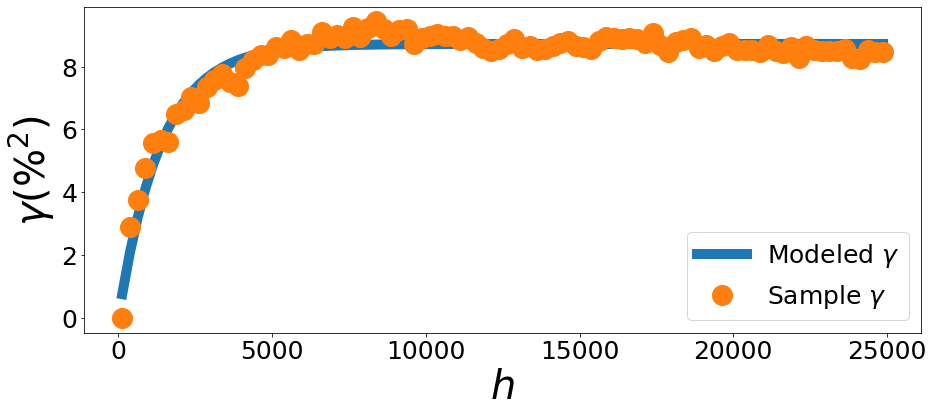

In [9]:
plt.figure(figsize=(15,6))
plt.plot(hd,exponential_semivariogram(hd,*popt),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Modeled $\gamma$',r'Sample $\gamma$'],fontsize=25)
plt.show()

In [10]:
import scipy.optimize

def bounded_linear_semivariogram(h,s,tau):
    return s*h

popt, pcov = scipy.optimize.curve_fit(bounded_linear_semivariogram,hd,gamma_s,bounds=([0,100],[100,10000]))

In [11]:
print(r'R2: %f' % sklearn.metrics.r2_score(bounded_linear_semivariogram(hd,*popt),gamma_s))

R2: -0.000205


In [12]:
plt.figure(figsize=(15,6))
plt.plot(hd,bounded_linear_semivariogram(hd,*popt),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Modeled $\gamma$',r'Sample $\gamma$'],fontsize=25)
plt.show()

In [29]:
import scipy.optimize

def spherical_semivariogram(h,c,tau):
    return c * ((3*h)/(2*tau) - 0.5*((h/tau)**3))

popt, pcov = scipy.optimize.curve_fit(spherical_semivariogram,hd,gamma_s)

In [30]:
print(r'R2: %f' % sklearn.metrics.r2_score(spherical_semivariogram(hd,*popt),gamma_s))

R2: 0.376651


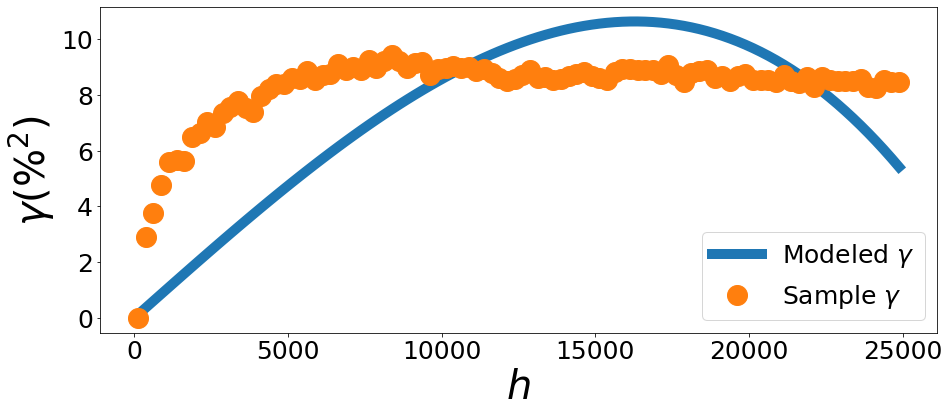

In [31]:
plt.figure(figsize=(15,6))
plt.plot(hd,spherical_semivariogram(hd,*popt),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Modeled $\gamma$',r'Sample $\gamma$'],fontsize=25)
plt.show()

## Discussion:
I would use the exponential semivariogram model for the region as its R^2 value is cloest to 1.

# 3. Ordinary Kriging (50 pts)

Using the data in the samples group in '/data/HW/HW8.nc', and assumming an exponential semivariogram with a sill ($c$) of 10.0 $\%^2$, a nugget of 0, and a range ($a$) of 1500 m, do the following:

A. Use ordinary kriging to reproduce the original map of sand (as found in the original_data group in `/data/HW/HW8.nc`).

B. Plot the reproduced map and the original map. Compare the two via $R^2$.

C. Compute the estimated mean squared error at each grid cell (kriging variance) and plot the map. Discuss the results. 

D. Although not an issue with this dataset, one of largest limitations of Kriging is that the observation covariance matrix can become too large. Another more practical approach is to only use the closest $n$ points to each point to which we interpolate. Setting $n = 10$, perform this "localized" ordinary kriging and compare the results to those from part B. 

E. Repeat part D. However, this time, set $n=1$. What simplistic deterministic spatial interpolation method does this mimic?

In [16]:
file = '/data/HW/HW8.nc'

import netCDF4 as nc
fp = nc.Dataset(file)

In [17]:
data = fp['original_data']['sand'][:]
x = fp['original_data']['x'][:]
y = fp['original_data']['y'][:]

In [18]:
import numpy as np
#Let's randomly sample n different points
nsamples = int(0.1*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Extract the data
data_points = []
for i in range(iy.size):
    data_points.append(data[iy[i],ix[i]])
data_points = np.array(data_points)

In [19]:
popt = [10, 1500]

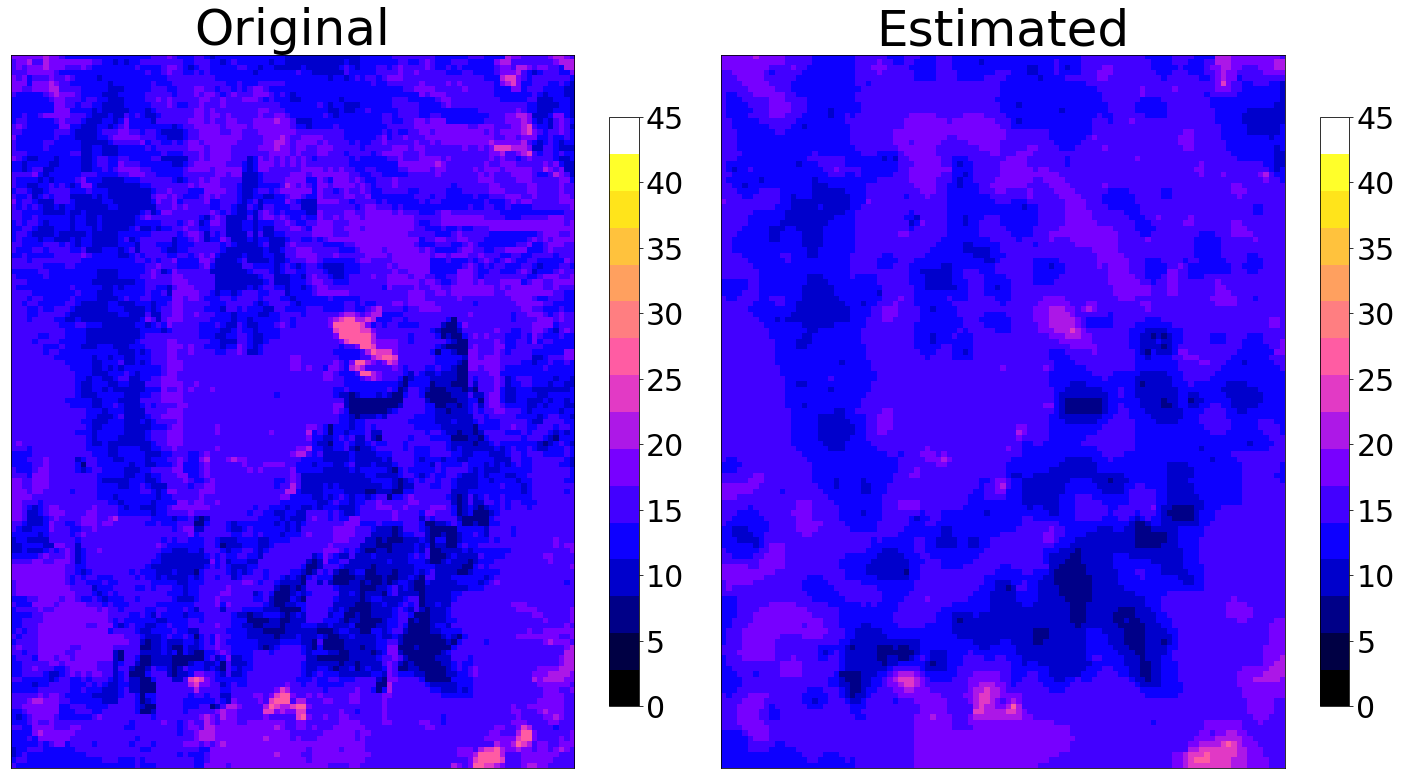

In [20]:
#Define variance
var = popt[0]
#Define tau
tau = popt[1]
#Define grid positioning
x_grid = x[xs]
y_grid = y[ys]
#Let's reshape our data to a 1d array
xg1d = x_grid.reshape(x_grid.size)
yg1d = y_grid.reshape(y_grid.size)
#Compute euclidean distances from observations to points on grid
dist = ((xg1d[:,np.newaxis] - x_points.T)**2 + (yg1d[:,np.newaxis] - y_points.T)**2)**0.5
#Compute covariance matrix C
C = var*np.exp(-dist/tau).T
#Compute euclidean distances from observatins to observations
dist = ((x_points[:,np.newaxis] - x_points.T)**2 + (y_points[:,np.newaxis] - y_points.T)**2)**0.5
#Compute covariance matrix Sigma
Sigma = var*np.exp(-dist/tau).T
#Append the extra information for the langrange multipliers
#Sigma_prime
Sigma_prime = np.zeros((Sigma.shape[0]+1,Sigma.shape[1]+1))
Sigma_prime[0:-1,0:-1] = Sigma[:]
Sigma_prime[-1,0:-1] = 1
Sigma_prime[0:-1,-1] = 1
#C_prime
C_prime = np.zeros((C.shape[0]+1,C.shape[1]))
C_prime[0:-1,:] = C[:,:]
C_prime[-1,:] = 1

# Solve for the weights
W = np.linalg.solve(Sigma_prime,C_prime)

#Compute zstar
zt = data_points[:]
zstar = np.sum(W[0:-1,:]*zt[:,np.newaxis],axis=0)
#Compute mse 
mse = var - np.sum(W[0:-1,:]*C_prime[0:-1,:],axis=0) - W[-1,:]

import matplotlib.cm as cm
import matplotlib.pyplot as plt
vmin = 0
vmax = 45
#Plot the original and kriged data side by side
ypred = zstar.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

## Discussion:
The black points at the right plot basically represents the observation data points, which explain their values of 0s. And for the places other than black points, more yellow means less accuracy. As shown in the graph, the places that are in yellow are mostly places that are distant from observation points, which means not as adequate information could be provided based on observation points as other places that are relatively less distant. And therefore the predictions for those places are less accurate.

In [21]:
import sklearn.model_selection

print(r'R2: %f' % sklearn.metrics.r2_score(data.reshape(data.size),ypred.reshape(ypred.size)))

R2: 0.610655


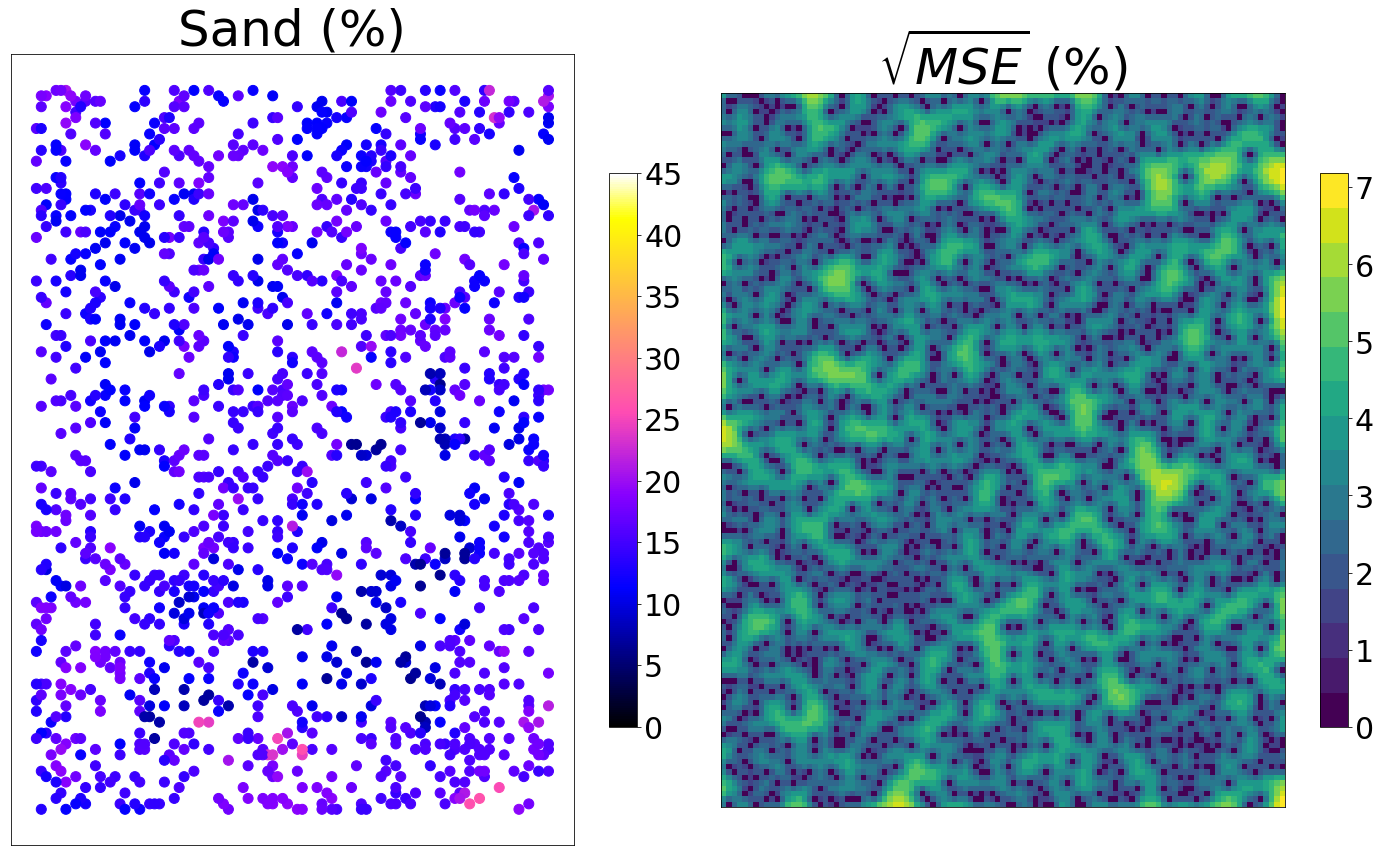

In [22]:
#Plot the original and kriged data side by side
mse_grid = mse.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(mse_grid,cmap=cm.get_cmap('viridis',16))
plt.xticks([])
plt.yticks([])
plt.title(r'$\sqrt{MSE}$ (%)',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.scatter(ix,np.max(iy)-iy,c=data_points,s=100,vmin=vmin,vmax=vmax,cmap='gnuplot2')
plt.xticks([])
plt.yticks([])
plt.title('Sand (%)',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

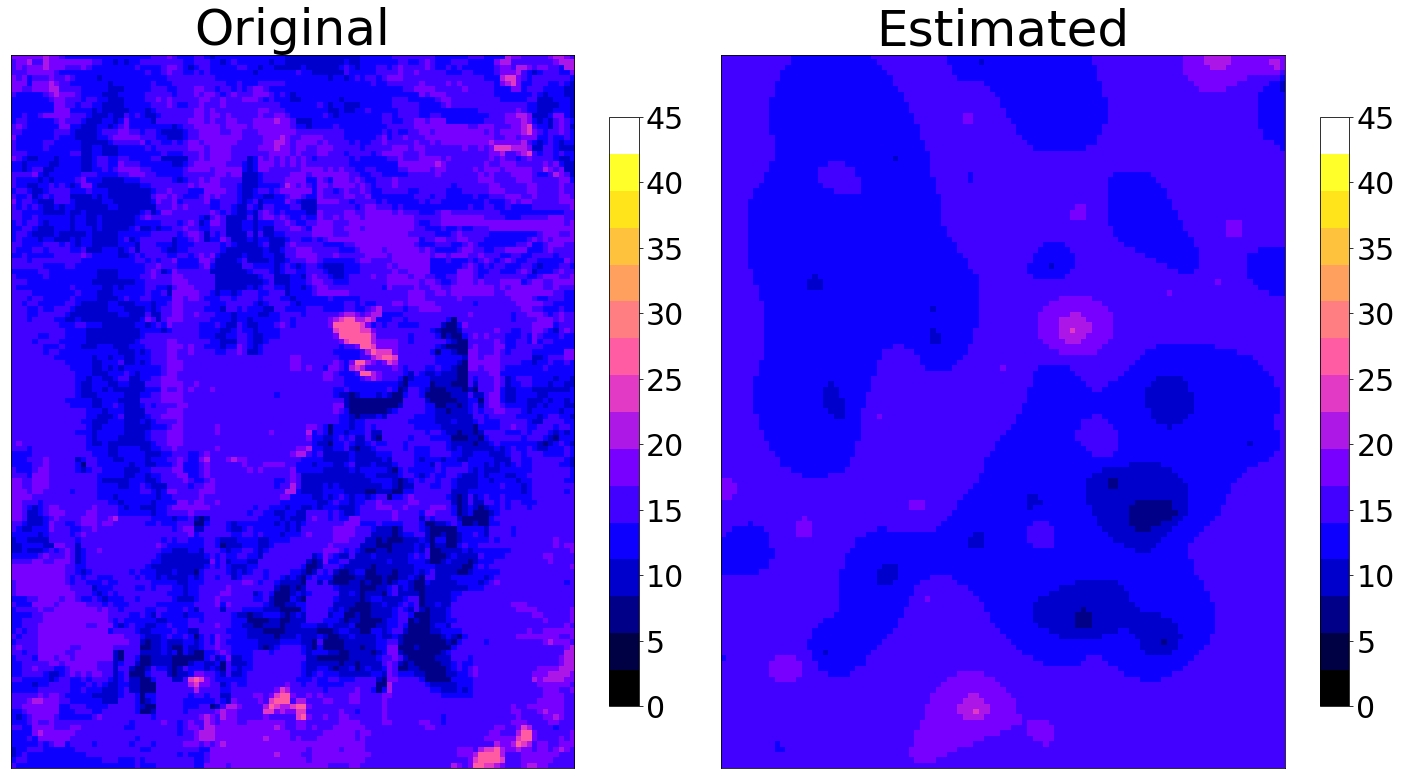

In [23]:
file = '/data/HW/HW8.nc'

import netCDF4 as nc
fp = nc.Dataset(file)

data = fp['original_data']['sand'][:]
x = fp['original_data']['x'][:]
y = fp['original_data']['y'][:]

import numpy as np
#Let's randomly sample n different points
nsamples = int(0.1*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Extract the data
data_points = []
for i in range(iy.size):
    data_points.append(data[iy[i],ix[i]])
data_points = np.array(data_points)

popt = [10, 1500]

#Define variance
var = popt[0]
#Define tau
tau = popt[1]
#Define grid positioning
x_grid = x[xs]
y_grid = y[ys]
#Let's reshape our data to a 1d array
xg1d = x_grid.reshape(x_grid.size)
yg1d = y_grid.reshape(y_grid.size)
#Compute euclidean distances from observations to points on grid
dist = ((xg1d[:,np.newaxis] - x_points[::10].T)**2 + (yg1d[:,np.newaxis] - y_points[::10].T)**2)**0.5
#Compute covariance matrix C
C = var*np.exp(-dist/tau).T
#Compute euclidean distances from observatins to observations
dist = ((x_points[::10,np.newaxis] - x_points[::10].T)**2 + (y_points[::10,np.newaxis] - y_points[::10].T)**2)**0.5
#Compute covariance matrix Sigma
Sigma = var*np.exp(-dist/tau).T
#Append the extra information for the langrange multipliers
#Sigma_prime
Sigma_prime = np.zeros((Sigma.shape[0]+1,Sigma.shape[1]+1))
Sigma_prime[0:-1,0:-1] = Sigma[:]
Sigma_prime[-1,0:-1] = 1
Sigma_prime[0:-1,-1] = 1
#C_prime
C_prime = np.zeros((C.shape[0]+1,C.shape[1]))
C_prime[0:-1,:] = C[:,:]
C_prime[-1,:] = 1

# Solve for the weights
W = np.linalg.solve(Sigma_prime,C_prime)

#Compute zstar
zt = data_points[:]
zstar = np.sum(W[0:-1,:]*zt[::10,np.newaxis],axis=0)
#Compute mse 
mse = var - np.sum(W[0:-1,:]*C_prime[0:-1,:],axis=0) - W[-1,:]

import matplotlib.cm as cm
import matplotlib.pyplot as plt
vmin = 0
vmax = 45
#Plot the original and kriged data side by side
ypred = zstar.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

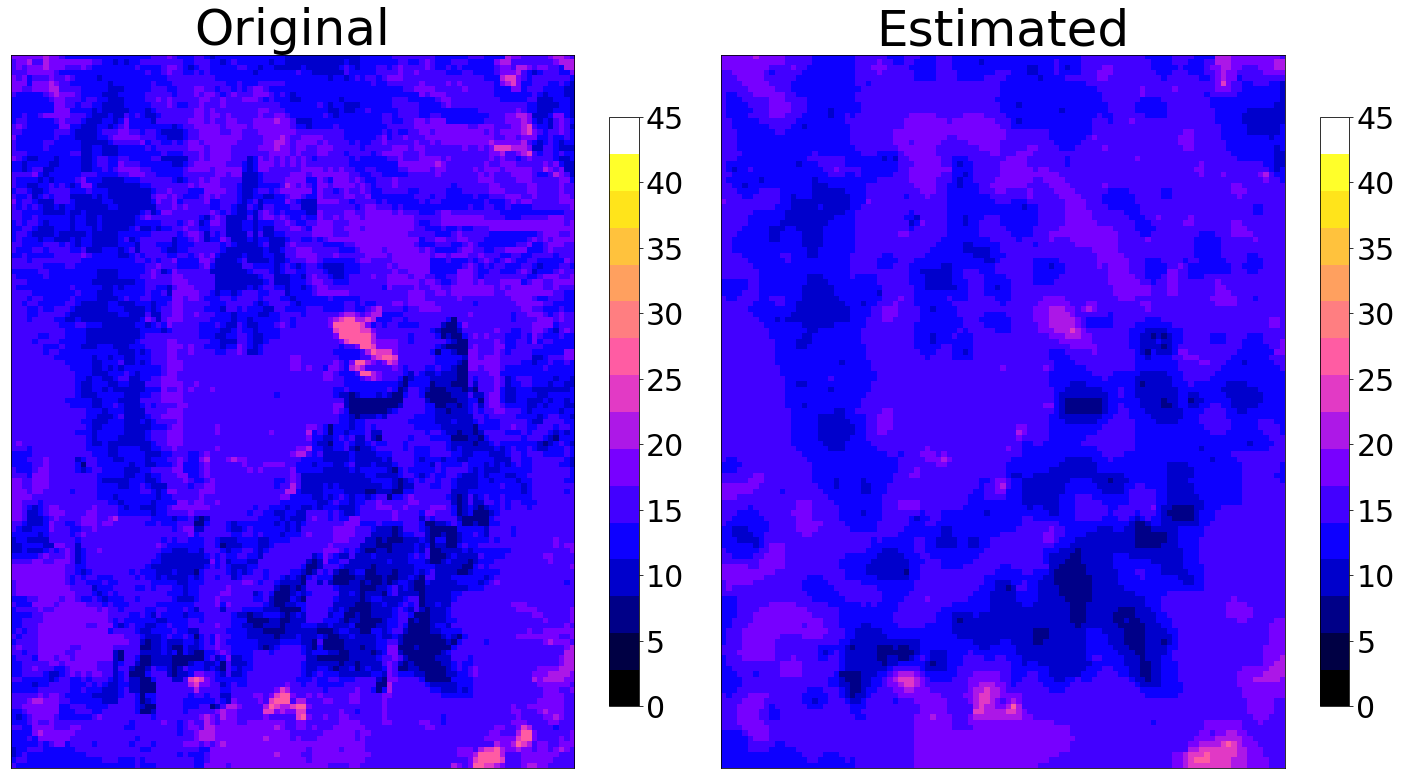

In [24]:
file = '/data/HW/HW8.nc'

import netCDF4 as nc
fp = nc.Dataset(file)

data = fp['original_data']['sand'][:]
x = fp['original_data']['x'][:]
y = fp['original_data']['y'][:]

import numpy as np
#Let's randomly sample n different points
nsamples = int(0.1*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Extract the data
data_points = []
for i in range(iy.size):
    data_points.append(data[iy[i],ix[i]])
data_points = np.array(data_points)

popt = [10, 1500]

#Define variance
var = popt[0]
#Define tau
tau = popt[1]
#Define grid positioning
x_grid = x[xs]
y_grid = y[ys]
#Let's reshape our data to a 1d array
xg1d = x_grid.reshape(x_grid.size)
yg1d = y_grid.reshape(y_grid.size)
#Compute euclidean distances from observations to points on grid
dist = ((xg1d[:,np.newaxis] - x_points[::1].T)**2 + (yg1d[:,np.newaxis] - y_points[::1].T)**2)**0.5
#Compute covariance matrix C
C = var*np.exp(-dist/tau).T
#Compute euclidean distances from observatins to observations
dist = ((x_points[::1,np.newaxis] - x_points[::1].T)**2 + (y_points[::1,np.newaxis] - y_points[::1].T)**2)**0.5
#Compute covariance matrix Sigma
Sigma = var*np.exp(-dist/tau).T
#Append the extra information for the langrange multipliers
#Sigma_prime
Sigma_prime = np.zeros((Sigma.shape[0]+1,Sigma.shape[1]+1))
Sigma_prime[0:-1,0:-1] = Sigma[:]
Sigma_prime[-1,0:-1] = 1
Sigma_prime[0:-1,-1] = 1
#C_prime
C_prime = np.zeros((C.shape[0]+1,C.shape[1]))
C_prime[0:-1,:] = C[:,:]
C_prime[-1,:] = 1

# Solve for the weights
W = np.linalg.solve(Sigma_prime,C_prime)

#Compute zstar
zt = data_points[:]
zstar = np.sum(W[0:-1,:]*zt[::1,np.newaxis],axis=0)
#Compute mse 
mse = var - np.sum(W[0:-1,:]*C_prime[0:-1,:],axis=0) - W[-1,:]

import matplotlib.cm as cm
import matplotlib.pyplot as plt
vmin = 0
vmax = 45
#Plot the original and kriged data side by side
ypred = zstar.reshape(x_grid.shape)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

## Discussion:
As n = 1, this is actually mimicing inverse distance weighting (IDW).